# Explore the ADL dataset (Archive for Danish Literature)

In [ ]:
## Import libraries
import pandas as pd
from bs4 import BeautifulSoup as bs
import os
import re
from collections import Counter
import math
import matplotlib.pyplot as plt

## Read the CSV file

Load the dataset from a CSV file into a pandas DataFrame

In [2]:
df = pd.read_csv(r'mekuni_adl_data/adl_dataset_metadata.csv', encoding='utf')

In [3]:
df.head(2)

,title,place,year,author,birth_year,death_year,xml_file_name,url
0,Bondens Søn ; Vadmelsfolk ; Vredens Børn. - 1919.,København,1918,"Aakjær, Jeppe.",1866,1930,aakjaer06val.xml,https://tekster.kb.dk/text/adl-texts-aakjaer06...
1,Digte 1885-1908. - 1918.,København,1918,"Aakjær, Jeppe.",1866,1930,aakjaer01val.xml,https://tekster.kb.dk/text/adl-texts-aakjaer01...


## Build BeautifulSoup elements from the XML data

In [ ]:
# Extract a list of XML file names from the DataFrame
xml_file_names = df['xml_file_name'].to_list()

# Build a function that can load an XML file with the BeautifulSoup library
def get_xml_file(file):

    try:
    
        file_path = r'mekuni_adl_data/adl_xml_files_sample_set/' + file
    
        with open(file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
    
        soup = bs(xml_content, 'lxml-xml')
    
        return soup

    except FileNotFoundError:
        pass

# Create a list of BeautifulSoup objects for each XML file
xml_soups = [get_xml_file(file) for file in xml_file_names]

# Create a new DataFrame with XML file names and their associated BeautifulSoup objects
df_soup = pd.DataFrame({'xml_file_name': xml_file_names,
                       'soup': xml_soups})

df_soup =  df_soup.dropna()

## Parse data from xml

The data in the "soup" column are BeautifulSoup elements, and we can read the text data that is in the various tags using the BeautifulSoup methods .find_all() and .get_text().
Review of the soup / xml showed that reading body tags and subsequently reading "p" and "l" tags inside "body" tags gives us most of the relevant text data, because this way we exclude most of the editor notes.

In [ ]:
# Write a function that extracts text data from specific tags (body, p, and l) in the XML
def get_text_from_body_tags(s):
    body_tags = s.find_all(['body']) 
    p_l_tags = [i.find_all(['p', 'l']) for i in body_tags]
    p_l_tags = [i for y in p_l_tags for i in y]
    text = [i.get_text() for i in p_l_tags]
    text = ' '.join(text).replace('\n', ' ').replace('\t', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply the function, extract text and save it as values in a new column
df_soup['text'] = df_soup['soup'].apply(lambda s : get_text_from_body_tags(s))

In [8]:
df_soup.head(2)

,xml_file_name,soup,text
3,bagger01val.xml,"[[\n, [\n, <fileDesc xml:id=""idm14062153911272...","Og hvorfor vil I vel skilles ad, Kan Kjærlighe..."
4,baggesen01val.xml,"[[\n, [\n, <fileDesc xml:id=""idm13989371598203...","F ortvivlelse! dig helliges min Sang, Og den, ..."


## Combine data
Now I can combine the data by merging the two dataframes; df and df_soup.

The "soup" column is now less useful, so I choose to drop it from the dataframe.

In [ ]:
# Connect the original DataFrame with the new DataFrame that contains the texts extracted from the xml files

mekuni_adl_dataset = pd.merge(df , df_soup, how='left', on='xml_file_name')

# Drop the 'soup' column because it will not be used anymore
mekuni_adl_dataset.drop(columns=['soup'], inplace=True)
mekuni_adl_dataset = mekuni_adl_dataset.dropna()

mekuni_adl_dataset.head(2)

,title,place,year,author,birth_year,death_year,xml_file_name,url,text
3,Udvalgte Skrifter.,København,1928,"Bagger, Carl.",1807,1846,bagger01val.xml,https://tekster.kb.dk/text/adl-texts-bagger01v...,"Og hvorfor vil I vel skilles ad, Kan Kjærlighe..."
4,Eventyr og Fortællinger. - 1889.,København,1889,"Baggesen, Jens.",1764,1826,baggesen01val.xml,https://tekster.kb.dk/text/adl-texts-baggesen0...,"F ortvivlelse! dig helliges min Sang, Og den, ..."


## Clean the text

To get more uniform text data, I use regex methods. I use .findall() to find all text between word boundaries (\b = word boundaries), that is not whitespace (i.e., spaces). I use .sub() and a regex pattern to avoid numbers, words containing numbers, words with a length of 1 or 2; and any sequence of more than one whitespace. Finally, I convert all letters to lowercase and return the cleaned text from the function.

In [ ]:
# A function to clean the text using regex methods
def clean(text): 

    # The .findall() method returns a list. Therefore, I use .join() to combine the list into a string
    text = ' '.join(re.findall(r'\b\S+\b', text))

    # Remove numbers and words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    
    # Remove short words (length 1 or 2)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove extra spaces (sometimes extra spaces occur during cleaning)
    text = re.sub(r'\s+', ' ', text) 

    # Convert to lowercase
    text = text.lower()

    # Return the text
    return text
    
# Apply the cleaning function to the text column
mekuni_adl_dataset['clean_text'] = mekuni_adl_dataset['text'].apply(lambda x: clean(x))

## Remove stopwords

I will use a collocation tool later, and I don't want to include stopwords in it, so I choose to create new text strings without stopwords to get better results from my collocation analysis.

In the "stopwords" folder, I have a txt file with stopwords. I read the file into the script, convert it to a list, and add space to add additional things to the list.

In [ ]:
# Load Danish stopwords from a txt file
sw_file = r'mekuni_adl_data/stopwords/adl_dataset_stopwords.txt'

with open(sw_file, 'r', encoding='utf-8') as f:
    stop_words = f.read().split()
    # Add more stopwords or grammatical characters as needed
    stop_words.extend(['_', '/', "'"])

# Write a function that removes stopwords from the text
def remove_stopwords(clean_text):   
    # From text string to word list
    tokens = clean_text.split()
    tokens_wo_stopwords = [i for i in tokens if i.lower() not in stop_words]
    clean_text_wo_stopwords = ' '.join(tokens_wo_stopwords)
    return clean_text_wo_stopwords

# Apply the stopwords function and remove stopwords
mekuni_adl_dataset['clean_text_wo_stopwords'] = mekuni_adl_dataset['clean_text'].apply( lambda x : remove_stopwords(x))

In [12]:
mekuni_adl_dataset.head(2)

,title,place,year,author,birth_year,death_year,xml_file_name,url,text,clean_text,clean_text_wo_stopwords
3,Udvalgte Skrifter.,København,1928,"Bagger, Carl.",1807,1846,bagger01val.xml,https://tekster.kb.dk/text/adl-texts-bagger01v...,"Og hvorfor vil I vel skilles ad, Kan Kjærlighe...",hvorfor vil vel skilles kan kjærlighed skifte...,skilles kjærlighed skiftes had harmfuldt sind ...
4,Eventyr og Fortællinger. - 1889.,København,1889,"Baggesen, Jens.",1764,1826,baggesen01val.xml,https://tekster.kb.dk/text/adl-texts-baggesen0...,"F ortvivlelse! dig helliges min Sang, Og den, ...",ortvivlelse dig helliges min sang den som hæn...,ortvivlelse helliges sang hænger hang hænge ør...


## Collocations

Collocation is a method to examine which words in a corpus appear more frequently than other words near selected keywords.

Add or replace the keywords with your own words.

In [ ]:
# Add keywords to the collocation analysis
keywords = ['fader', 'moder', 'barn']

in_data_list = ' '.join(mekuni_adl_dataset['clean_text_wo_stopwords']).split()

# Prepare a dictionary to keep track of how often other words appear near the keywords
keyword_proximity_counts = {keyword: Counter() for keyword in keywords}

# Adjust "proximity"
window_size = 10

# Count words near each keyword
for i, token in enumerate(in_data_list):
    if token in keywords:
        # Define the window / proximity around the keyword
        start = max(0, i - window_size)
        end = min(len(in_data_list), i + window_size + 1)
        # Count the words within the window, but exclude the keyword
        for j in range(start, end):
            if j != i:
                keyword_proximity_counts[token][in_data_list[j]] += 1

# Filter words that appear with a frequency fewer times than or equal to a selected threshold value
# Adjust the threshold value as needed
threshold_value = 80
filtered_keyword_proximity_counts = {
    keyword: Counter({term: count for term, count in counts.items() if count >= 80})
    for keyword, counts in keyword_proximity_counts.items()}

## Visualize the collocations
If I print the contents of the variable "filtered_keyword_proximity_counts", we can see the different keywords together with the collocations.

These are the collocations found after we have removed stopwords and adjusted the window size to 10. It can be a bit confusing to see the data in the printed form, so I have chosen to use matplotlib to visualize the collocations with bar charts.

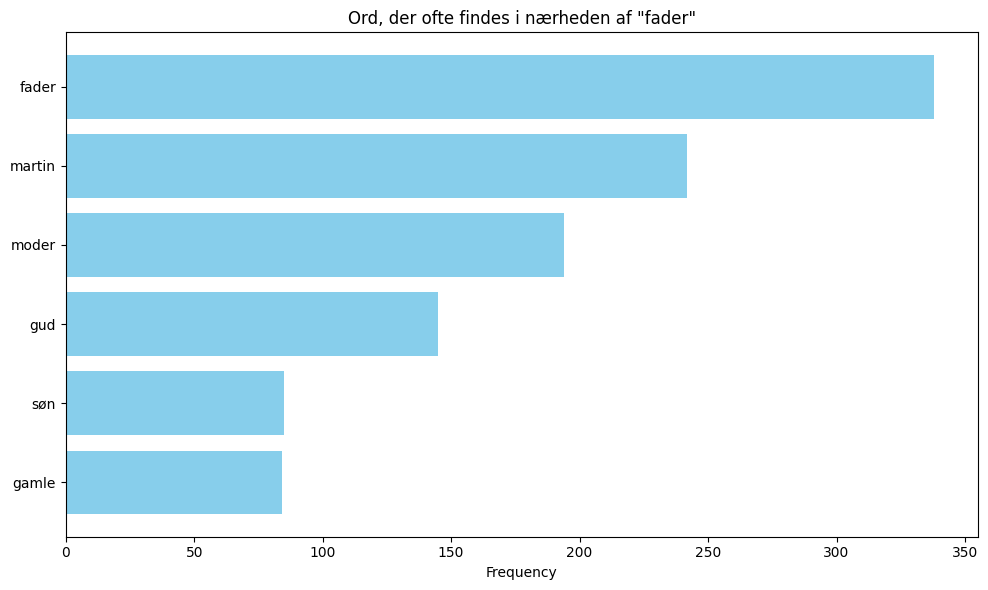

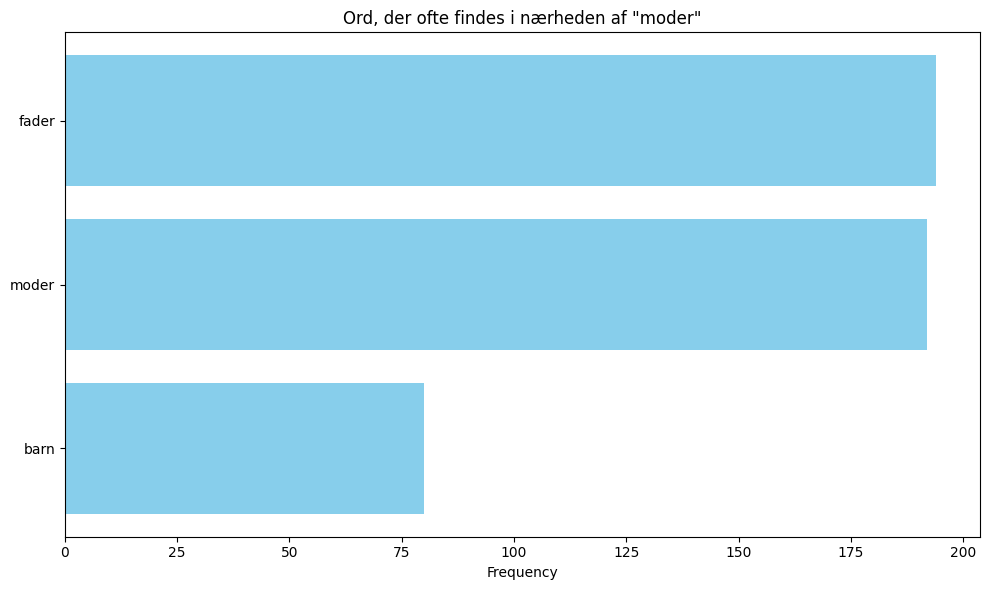

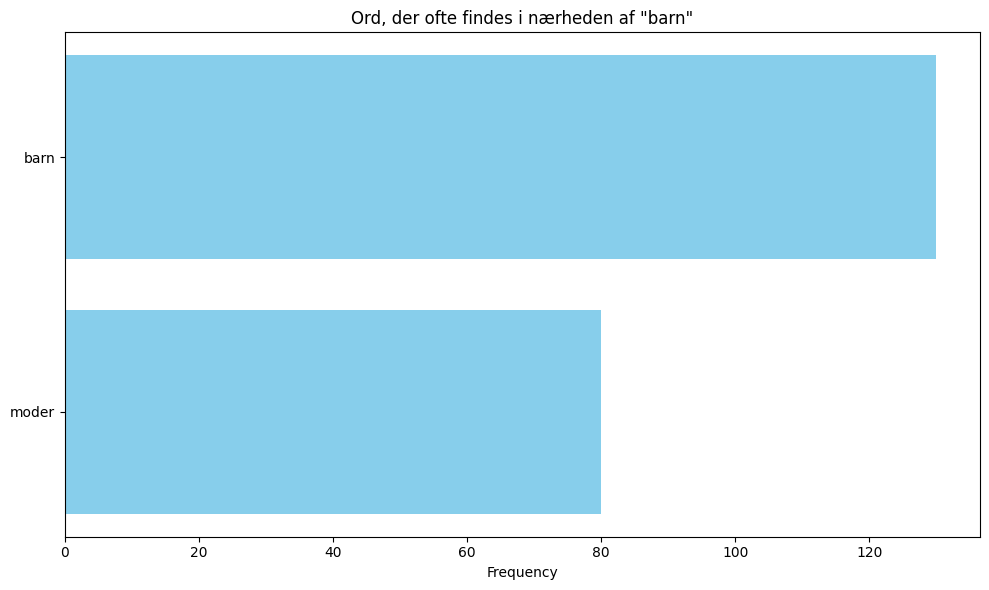

In [ ]:
# Convert each group's count to a DataFrame and save them in an empty list
dfs = []
for keyword, counter in filtered_keyword_proximity_counts.items():
    df = pd.DataFrame(counter.items(), columns=['Word', 'Frequency'])
    df['Keyword_Group'] = keyword
    dfs.append(df)

# Concatenate all DataFrames from the list
all_data = pd.concat(dfs, ignore_index=True)

# Create individual bar charts for each group of keywords
for keyword in filtered_keyword_proximity_counts.keys():
    df_subset = all_data[all_data['Keyword_Group'] == keyword]
    plt.figure(figsize=(10,6))
    df_subset = df_subset.sort_values(by='Frequency', ascending=False).head(10)
    plt.barh(df_subset['Word'], df_subset['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Words often found near "{keyword}"')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()